# CNN - Modelling (Binary + KNN + VGG)

# 1. Construct `ImageDataGenerator` Instance

In [1]:
import tensorflow as tf
%matplotlib inline

print(tf.__version__)

2.4.2


In [2]:
! nvidia-smi

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Thu Aug 12 07:35:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%    

We center and standardize all images at per image level.

Image flips, 180 degree image rotations and image brightness is suitable for data augmentation. However, shift and zoom are not appropriate because some crackes are located at the edge of some images. Zoom and shift may remove those crackes.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True)

datagen_test = ImageDataGenerator(samplewise_center=True,
                                   samplewise_std_normalization=True)

Then, load the data from directory: to relieve the burden of memory usage, import the image as 150 $\times$ 150 squares.

In [4]:
SRC_BINARY = "/home/ubuntu/crack/KNN-Binary/"

from crack_utils import load_binary_dataset

x_train, x_test, y_train, y_test = load_binary_dataset(SRC_BINARY, (150, 150))

train_it = datagen_train.flow(x_train, y_train, batch_size=64, seed=100)
test_it = datagen_test.flow(x_test, y_test, batch_size=64, seed=100)

# 2. VGG Model

## 2.1 Baseline Model 

We consider VGG blocks in our baseline model.

### 2.2.2 One Block VGG Model

In [5]:
from crack_utils import vgg_block, classification_block, binary_compile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def one_block_VGG():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add vgg module
    layer = vgg_block(visible, 32, 1)
    # add classification block
    layer = classification_block(layer, 16)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = one_block_VGG()
binary_compile(model, 0.001, 0.9)
model.summary()

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2021-08-12 07:35:36.977 ip-172-31-5-51:18619 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-12 07:35:36.999 ip-172-31-5-51:18619 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      320       
________________

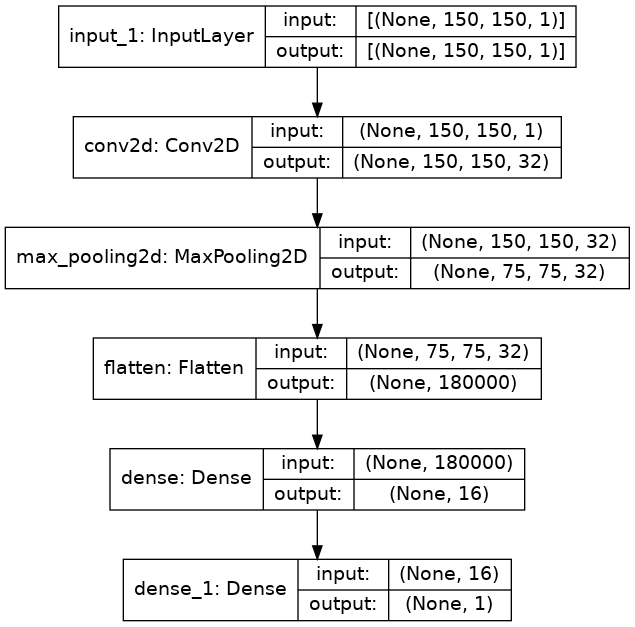

In [6]:
from tensorflow.keras.utils import plot_model

# plot model architecture
plot_model(model, show_shapes=True, to_file='model_image/Bi_KNN_VGG_1.png')

In [7]:
%%time

histories = dict()

histories["Bi_KNN_VGG_1"] = model.fit(x=train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 15s, sys: 4.41 s, total: 1min 19s
Wall time: 1min 6s


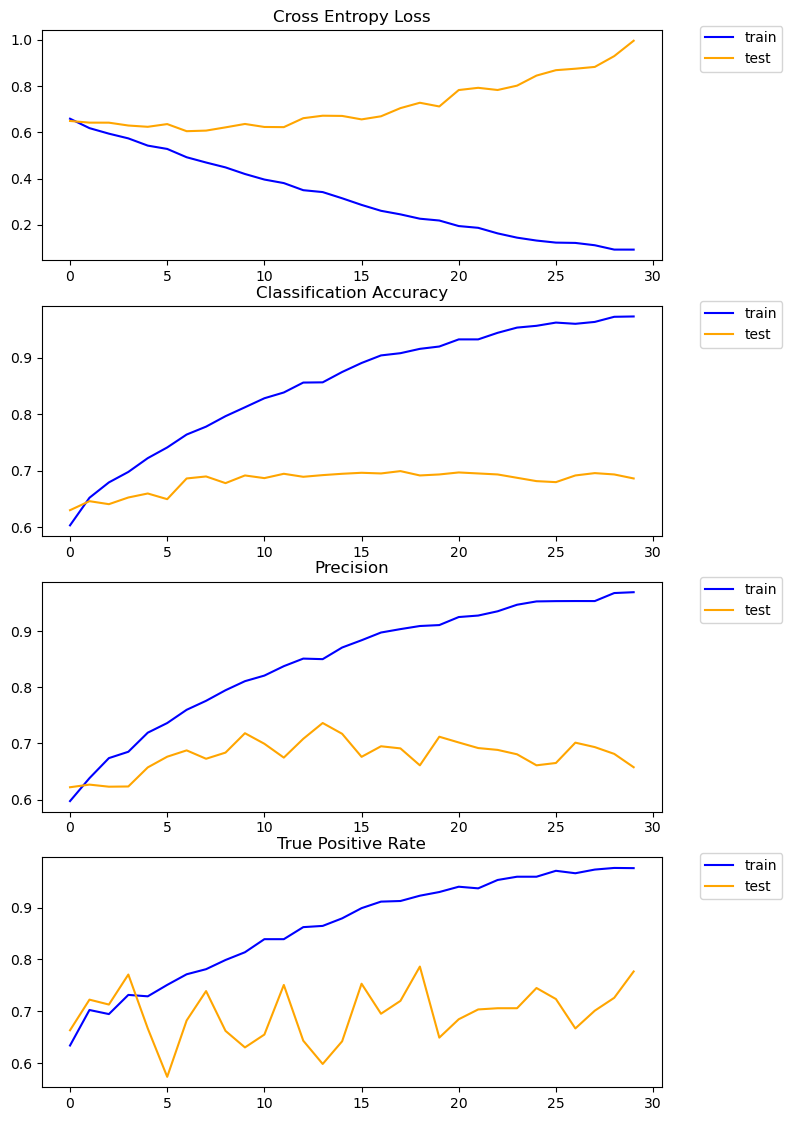

In [8]:
from crack_utils import summarize_diagnostics_binary
                                           
summarize_diagnostics_binary(histories["Bi_KNN_VGG_1"], "model_plot/Bi_KNN_VGG_1.png")

In [9]:
from crack_utils import show_result

show_result(model, test_it)

Test loss: 1.00
Test Accuracy: 0.69
Test Precision: 0.66
Test True Positive Rate: 0.78


### 2.1.2 Two Block VGG Model

In [10]:
def two_block_VGG():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add vgg module
    layer = vgg_block(visible, 32, 1)
    layer = vgg_block(layer, 64, 1)
    # add classification block
    layer = classification_block(layer, 16)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = two_block_VGG()
binary_compile(model, 0.001, 0.9)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 87616)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1401

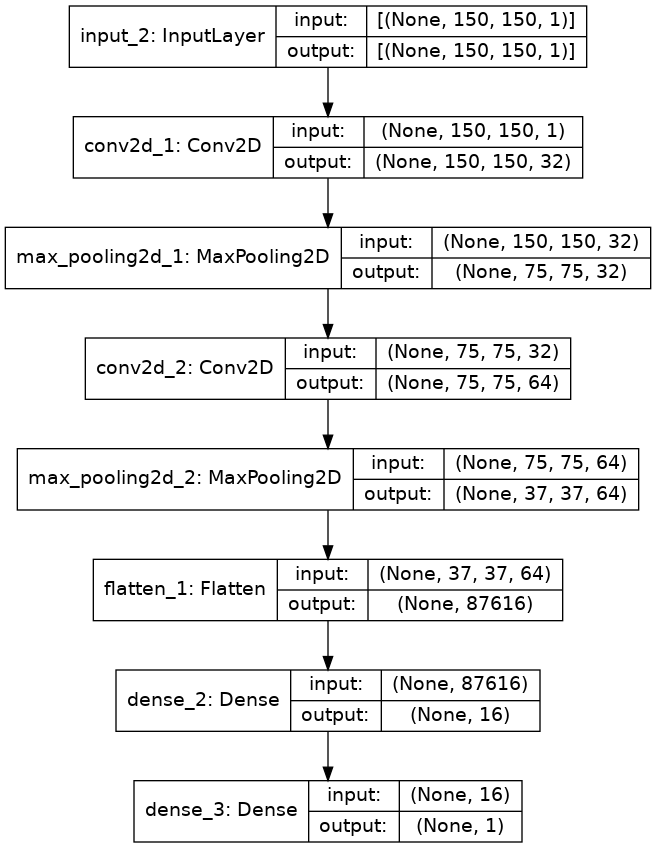

In [11]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='model_image/Bi_KNN_VGG_2.png')

In [12]:
%%time

histories["Bi_KNN_VGG_2"] = model.fit(train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 25s, sys: 5.93 s, total: 1min 31s
Wall time: 1min 34s


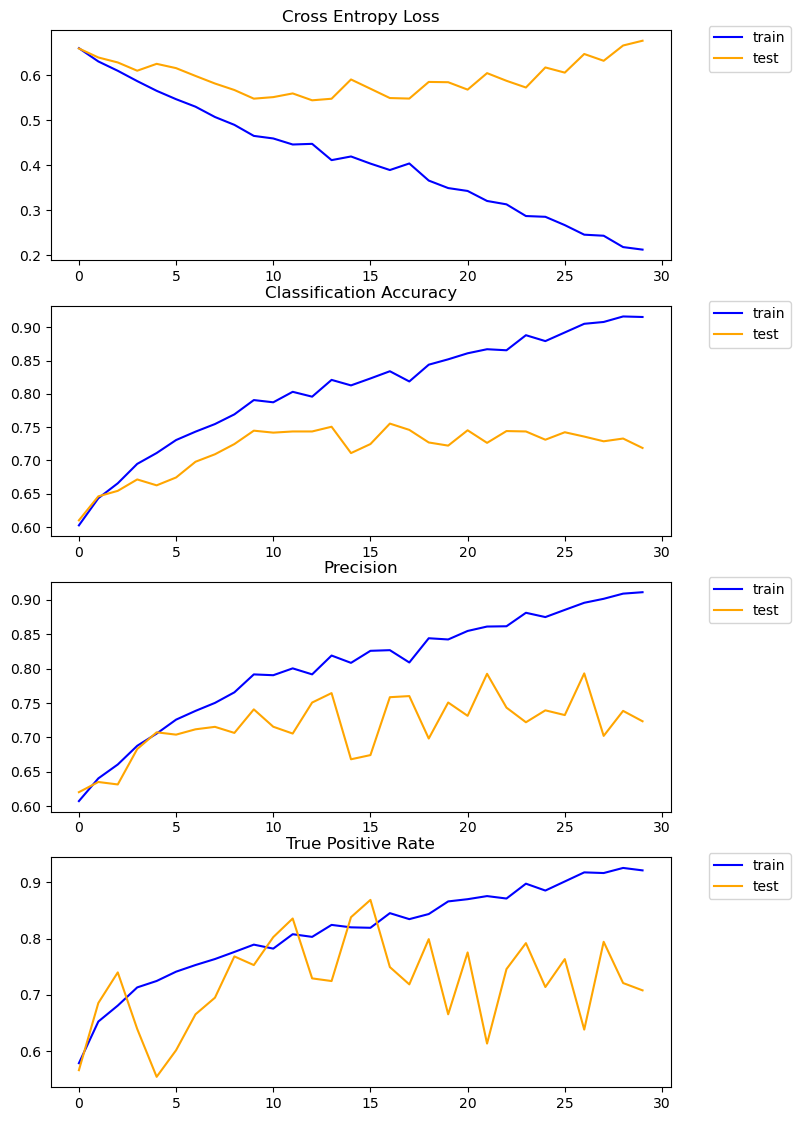

In [13]:
summarize_diagnostics_binary(histories["Bi_KNN_VGG_2"], "model_plot/Bi_KNN_VGG_2.png")

In [14]:
show_result(model, test_it)

Test loss: 0.68
Test Accuracy: 0.72
Test Precision: 0.72
Test True Positive Rate: 0.71


### 2.1.3 Three Block VGG Model

In [15]:
def three_block_VGG():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add vgg module
    layer = vgg_block(visible, 32, 1)
    layer = vgg_block(layer, 64, 1)
    layer = vgg_block(layer, 128, 1)
    # add classification block
    layer = classification_block(layer, 16)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = three_block_VGG()
binary_compile(model, 0.001, 0.9)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 128)       0   

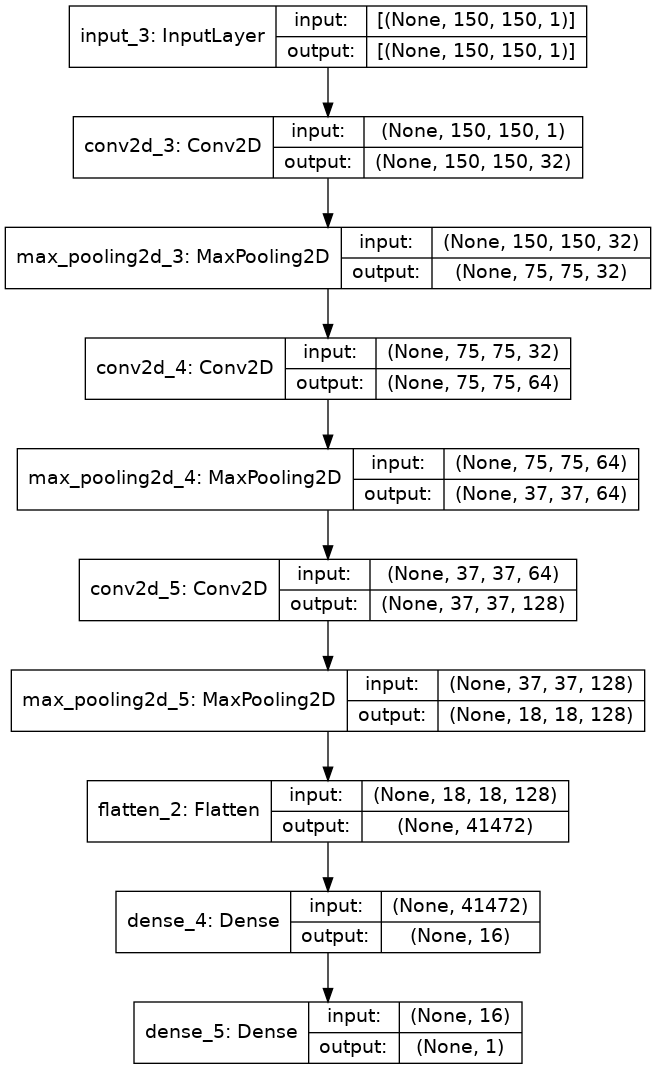

In [16]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='model_image/Bi_KNN_VGG_3.png')

In [17]:
%%time

histories["Bi_KNN_VGG_3"] = model.fit(train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 32s, sys: 5.98 s, total: 1min 38s
Wall time: 1min 55s


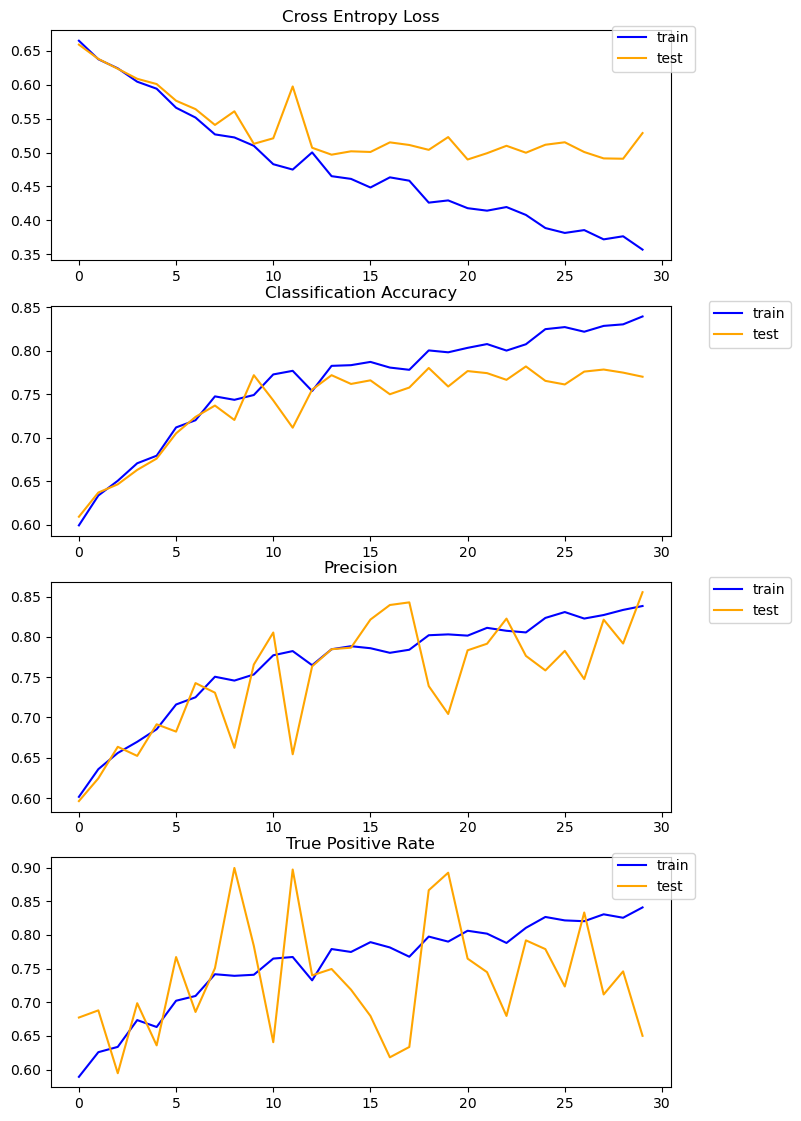

In [18]:
summarize_diagnostics_binary(histories["Bi_KNN_VGG_3"], "model_plot/Bi_KNN_VGG_3.png")

In [19]:
show_result(model, test_it)

Test loss: 0.53
Test Accuracy: 0.77
Test Precision: 0.86
Test True Positive Rate: 0.65


## 2.2 Model Improvements

### 2.2.1 Dropout Regularization



In [20]:
from tensorflow.keras.layers import Dropout

def three_block_VGG_dropout():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add vgg module
    layer = vgg_block(visible, 32, 1)
    layer = Dropout(0.2)(layer)
    layer = vgg_block(layer, 64, 1)
    layer = Dropout(0.3)(layer)
    layer = vgg_block(layer, 128, 1)
    layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 16)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = three_block_VGG_dropout()
binary_compile(model, 0.001, 0.9)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0   

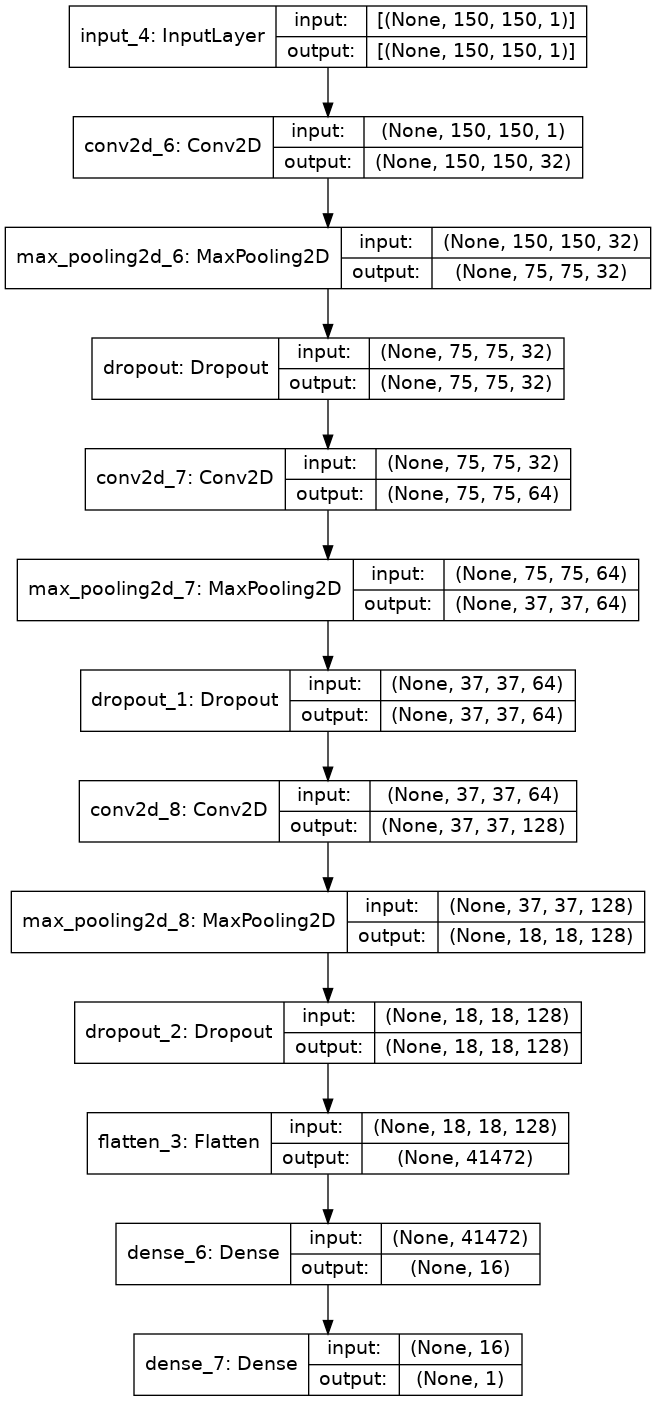

In [21]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='model_image/Bi_KNN_VGG_3_dropout.png')

In [22]:
%%time

histories["Bi_KNN_VGG_3_dropout"] = model.fit(train_it, 
              steps_per_epoch=len(train_it), validation_data=test_it, 
              validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 32s, sys: 6.07 s, total: 1min 38s
Wall time: 2min 5s


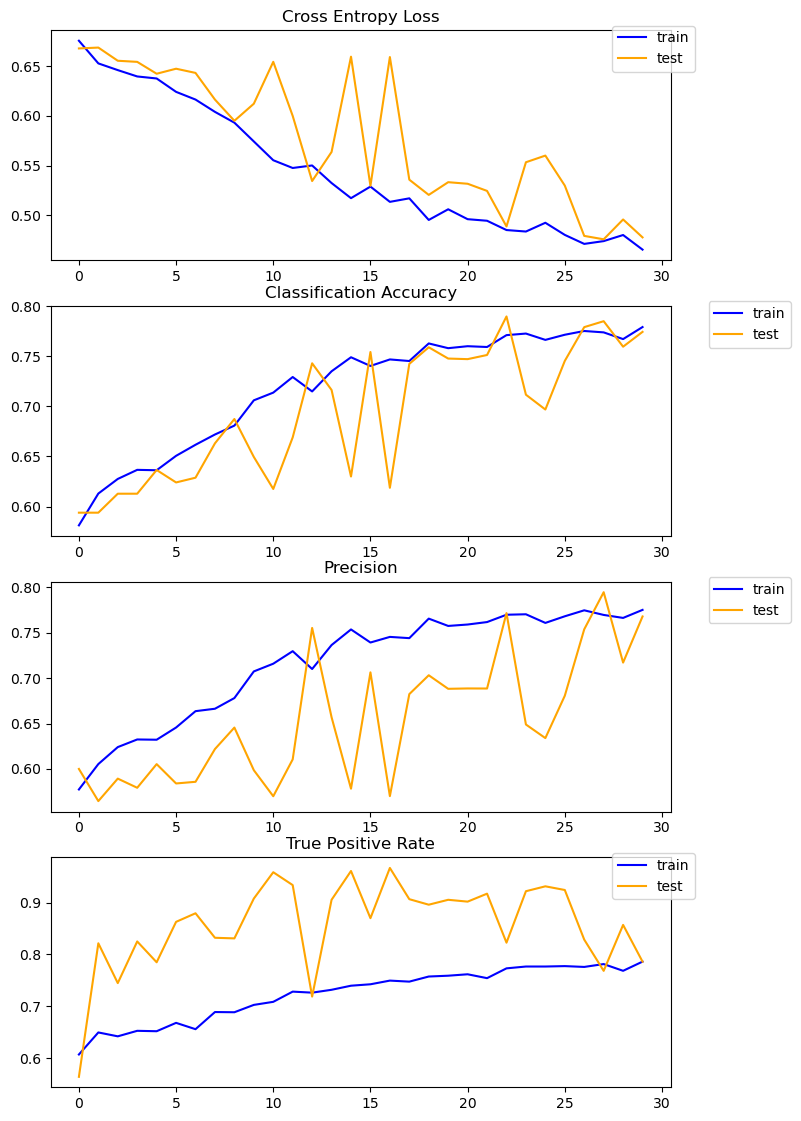

In [23]:
summarize_diagnostics_binary(histories["Bi_KNN_VGG_3_dropout"], "model_plot/Bi_KNN_VGG_3_dropout.png")

In [24]:
show_result(model, test_it)

Test loss: 0.48
Test Accuracy: 0.77
Test Precision: 0.77
Test True Positive Rate: 0.79


### 2.2.1 Weight Decay + Dropout

In [25]:
from tensorflow.keras.regularizers import l2

def three_block_VGG_dropout_decay():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add vgg module
    layer = vgg_block(visible, 32, 1, decay=l2(0.01))
    layer = Dropout(0.2)(layer)
    layer = vgg_block(layer, 64, 1, decay=l2(0.01))
    layer = Dropout(0.3)(layer)
    layer = vgg_block(layer, 128, 1, decay=l2(0.01))
    layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 16, decay=l2(0.01))
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = three_block_VGG_dropout_decay()
binary_compile(model, 0.001, 0.9)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 37, 37, 64)        0   

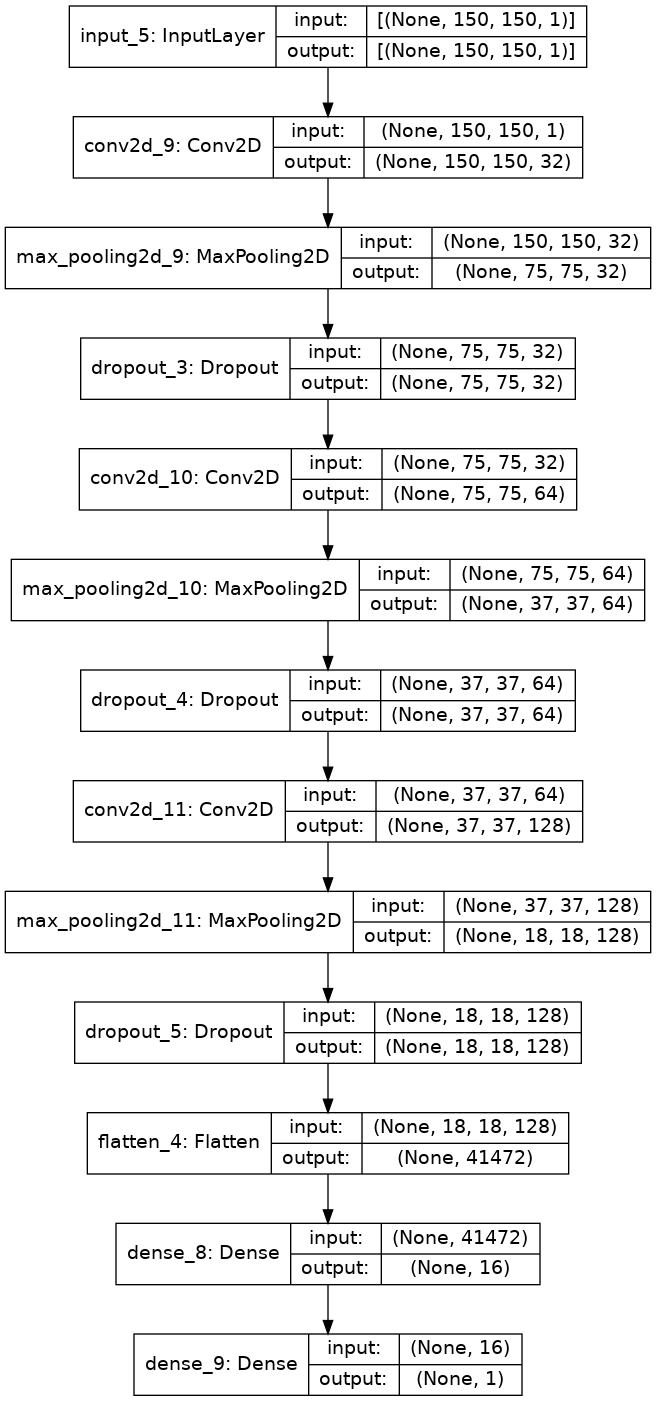

In [26]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='model_image/Bi_KNN_VGG_3_dropout_decay.png')

In [27]:
%%time

histories["Bi_KNN_VGG_3_dropout_decay"] = model.fit(train_it, 
                               steps_per_epoch=len(train_it), validation_data=test_it, 
                               validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 35s, sys: 7.44 s, total: 1min 43s
Wall time: 2min 6s


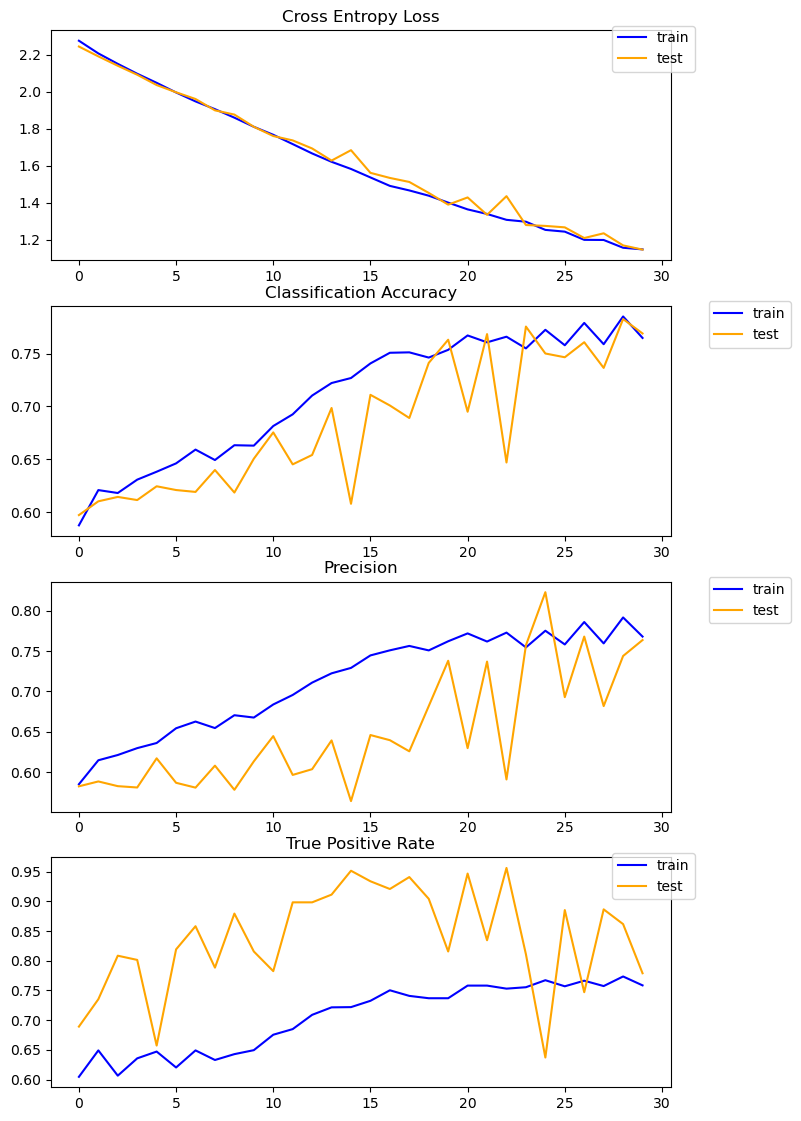

In [28]:
summarize_diagnostics_binary(histories["Bi_KNN_VGG_3_dropout_decay"], 
                             "model_plot/Bi_KNN_VGG_3_dropout_decay.png")

In [29]:
show_result(model, test_it)

Test loss: 1.15
Test Accuracy: 0.77
Test Precision: 0.76
Test True Positive Rate: 0.78


# 3. Summary

30th epoch result:

In [30]:
from crack_utils import get_percentile_result

result_30 = get_percentile_result(histories, 30)
result_30.round(2)

,Bi_KNN_VGG_1,Bi_KNN_VGG_2,Bi_KNN_VGG_3,Bi_KNN_VGG_3_dropout,Bi_KNN_VGG_3_dropout_decay
Loss,1.00,0.68,0.53,0.48,1.15
Accuracy,0.69,0.72,0.77,0.77,0.77
Precision,0.66,0.72,0.86,0.77,0.76
TPR,0.78,0.71,0.65,0.79,0.78


21-30 epochs (Average):

In [31]:
from crack_utils import get_avg_result

avg_result = get_avg_result(histories, start_epoch=21)
avg_result.round(2)

,Bi_KNN_VGG_1,Bi_KNN_VGG_2,Bi_KNN_VGG_3,Bi_KNN_VGG_3_dropout,Bi_KNN_VGG_3_dropout_decay
Loss,0.86,0.62,0.51,0.51,1.26
Accuracy,0.69,0.73,0.77,0.75,0.75
Precision,0.68,0.74,0.79,0.72,0.73
TPR,0.72,0.72,0.74,0.86,0.82


Compare each model:

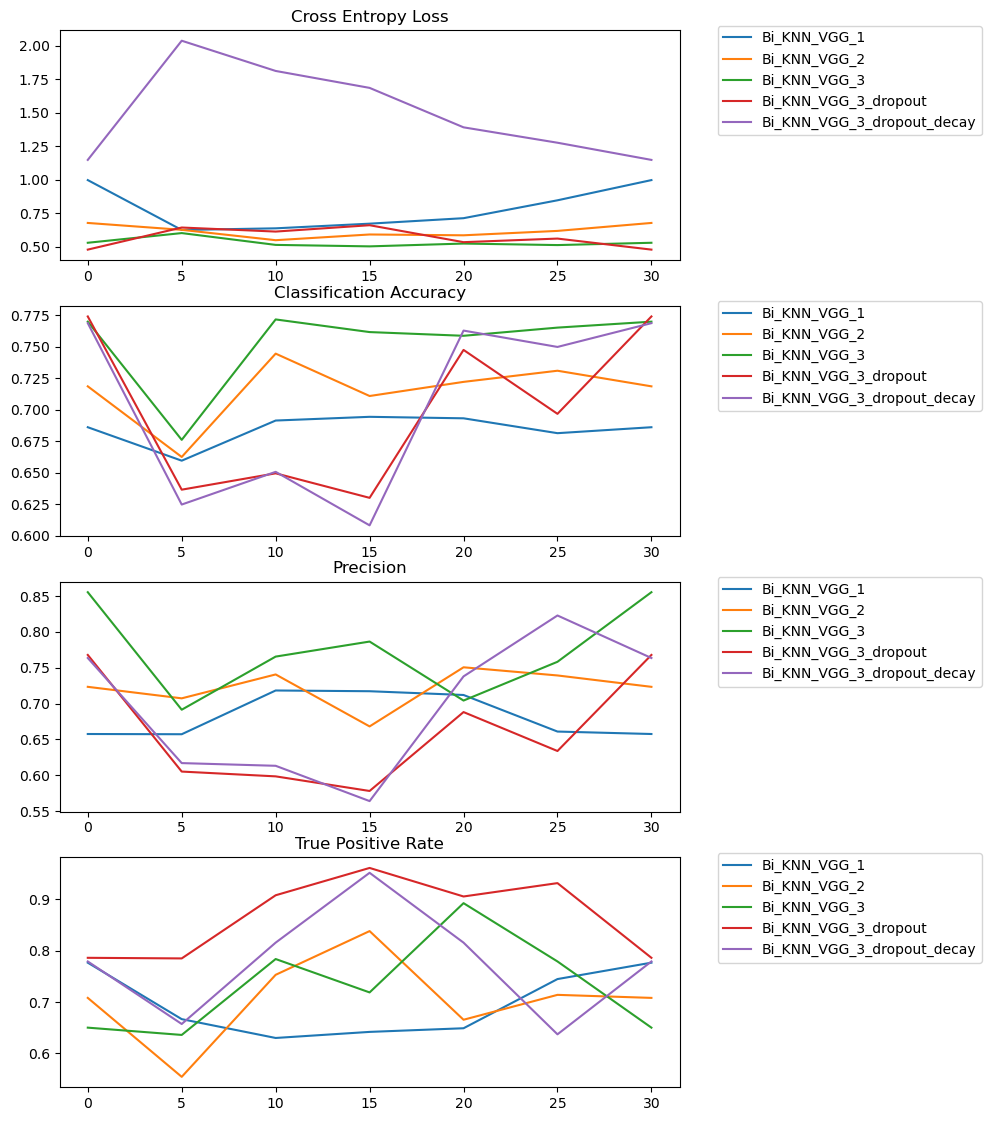

In [32]:
from crack_utils import compare_all_result

compare_all_result(histories, filename="model_plot/Compare_Bi_KNN_VGG.png", end=30, step=5)

Save epochs history:

In [33]:
from crack_utils import save_history

save_history(histories, folder="epochs_history")